### Decision Tree Model Tuning for 2016 - 2020 Data (exports) with SMOTE

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import modelinghelper as helper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree

import joblib
import os
from datetime import datetime

# supress future warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [28]:
#set up random seed
rng = 42

# set up folder to save results
output_path = 'export_run8_SMOTEsampling_gridsearchCV'
dataset = 'export_SMOTE'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")

# file name
prefix = f'{output_path}/{dataset}'

Folder already exists


In [14]:
# read in data
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [15]:
df['ship_date_mm'] = df['ship_date_mm'].astype(str)

In [16]:
df.describe()

,control_number,qty,value,qty_new,ship_date_yyyy
count,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06
mean,2.018142e+09,1.955213e+06,9.658016e+03,1.954949e+06,2.017558e+03
std,1.263350e+06,2.644078e+08,9.355053e+05,2.644078e+08,1.279415e+00
min,2.014539e+09,-1.000000e+00,0.000000e+00,-1.000000e+00,2.016000e+03
25%,2.016978e+09,1.500000e+00,5.100000e+01,1.000000e+00,2.016000e+03
50%,2.017984e+09,9.000000e+00,3.180000e+02,8.000000e+00,2.017000e+03
75%,2.019505e+09,9.300000e+01,2.104000e+03,8.600000e+01,2.019000e+03
max,2.020755e+09,9.990708e+10,1.242236e+09,9.990708e+10,2.020000e+03


In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

export_df = helper.df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 1590505 rows × 12 columns
# export: 299340 rows × 12 columns

#### Modeling Pipeline

In [7]:
X_train, X_test, y_train, y_test = helper.data_split(export_df)

#### Decision Tree

In [8]:
# run 2 after updating SMOTE parameters
clf = DecisionTreeClassifier(random_state=rng)
dt_params={
    'clf__class_weight':[None,
                         'balanced', 
                         #{0:100, 1:1}, 
                         {0:50, 1:1}],
    'clf__max_depth': [2,3,4,5,6,7,8,9,10, None]
}

start = datetime.now()
dt_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, dt_params, imbalance_pipe=True) 
end = datetime.now()
print(f'model run time: {end - start}')

dt_pipe

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__class_weight=None, clf__max_depth=2;, score=0.455 total time=   2.4s
[CV 2/5] END clf__class_weight=None, clf__max_depth=2;, score=0.421 total time=   2.3s
[CV 3/5] END clf__class_weight=None, clf__max_depth=2;, score=0.631 total time=   2.3s
[CV 4/5] END clf__class_weight=None, clf__max_depth=2;, score=0.630 total time=   2.2s
[CV 5/5] END clf__class_weight=None, clf__max_depth=2;, score=0.500 total time=   2.1s
[CV 1/5] END clf__class_weight=None, clf__max_depth=3;, score=0.657 total time=   2.3s
[CV 2/5] END clf__class_weight=None, clf__max_depth=3;, score=0.553 total time=   2.4s
[CV 3/5] END clf__class_weight=None, clf__max_depth=3;, score=0.592 total time=   2.4s
[CV 4/5] END clf__class_weight=None, clf__max_depth=3;, score=0.453 total time=   2.4s
[CV 5/5] END clf__class_weight=None, clf__max_depth=3;, score=0.622 total time=   2.4s
[CV 1/5] END clf__class_weight=None, clf__max_depth=4;, score=0.610 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('sampling',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced', {0: 50, 1: 1}],
                         'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
             scoring='recall', verbose=3)

In [29]:
joblib.dump(dt_pipe, f'{prefix}_dt_pipe.joblib')

['export_run8_SMOTEsampling_gridsearchCV/export_SMOTE_dt_pipe.joblib']

#### Random Forest

In [11]:
clf = RandomForestClassifier(random_state=rng)
rf_params={
    'clf__n_estimators':[4, 10, 20, 30, 50, 100],
    'clf__max_depth': [None, 3, 5, 7, 9],
    'clf__class_weight':['balanced', None]
}

%time rf_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params, imbalance_pipe=True) 
rf_pipe

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.364 total time=   4.0s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.301 total time=   4.1s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.377 total time=   3.9s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.345 total time=   3.9s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.389 total time=   4.0s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.400 total time=   7.3s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.343 total time=   7.6s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=10;, score=0.397 total time=   7.4s
[CV 4/5] END cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('sampling',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced', None],
                         'clf__max_depth': [None, 3, 5, 7, 9],
                         'clf__n_estimators': [4, 10, 20, 30, 50, 100]},
             scoring='recall', verbose=3)

In [30]:
joblib.dump(rf_pipe, f'{prefix}_rf_pipe.joblib')

['export_run8_SMOTEsampling_gridsearchCV/export_SMOTE_rf_pipe.joblib']

In [18]:
clf = RandomForestClassifier(random_state=rng)
rf_params2={
    'clf__n_estimators':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'clf__max_depth': [2, 3, 5, 7, 9],
    'clf__class_weight':['balanced']
}

%time rf_pipe_2 = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params2, imbalance_pipe=True) 
rf_pipe_2

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=2;, score=0.717 total time=   2.2s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=2;, score=0.470 total time=   2.1s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=2;, score=0.501 total time=   2.1s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=2;, score=0.536 total time=   2.1s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=2;, score=0.464 total time=   2.1s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=3;, score=0.748 total time=   2.3s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=3;, score=0.468 total time=   2.2s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=2, clf__n_estimators=3;, score=0.499 total time=   2.2s
[CV 4/5] END clf__class_weight=balanced, c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('sampling',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced'],
                         'clf__max_depth': [2, 3, 5, 7, 9],
                         'clf__n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='recall', verbose=3)

In [31]:
joblib.dump(rf_pipe_2, f'{prefix}_rf_pipe_2.joblib')

['export_run8_SMOTEsampling_gridsearchCV/export_SMOTE_rf_pipe_2.joblib']

Decision Tree (best model)
 [[  406   237]
 [16097 58095]]


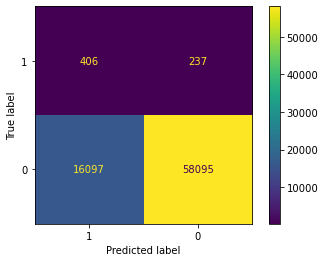

In [25]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()
    
    

Random Forest (best model)
 [[  426   217]
 [14924 59268]]


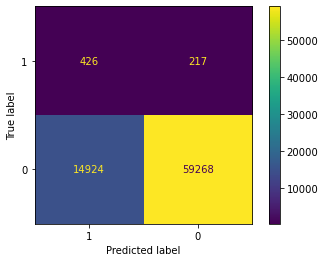

In [26]:
outputs = True
rf_predicted = rf_pipe.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

Random Forest 2 (best model)
 [[  424   219]
 [14951 59241]]


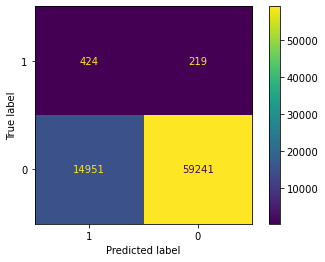

In [27]:
outputs = True
rf_predicted_2 = rf_pipe_2.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_2, labels = [1,0])
if outputs:
    print('Random Forest 2 (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

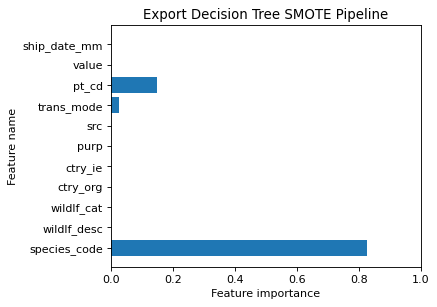

Feature importances: [0.         0.         0.14846076 0.02613811 0.         0.
 0.         0.         0.         0.         0.82540113]


In [42]:
from adspy_shared_utilities import plot_feature_importances
from adspy_shared_utilities import plot_decision_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(dt_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Decision Tree SMOTE Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(dt_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

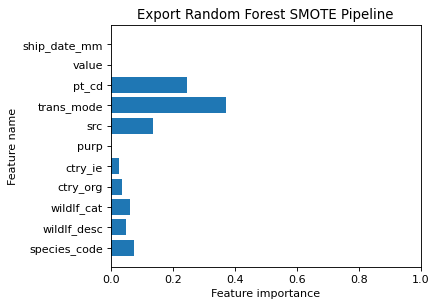

Feature importances: [0.         0.         0.2445449  0.37149867 0.13569229 0.
 0.02649245 0.035395   0.06295533 0.04962151 0.07379986]


In [41]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(rf_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Random Forest SMOTE Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

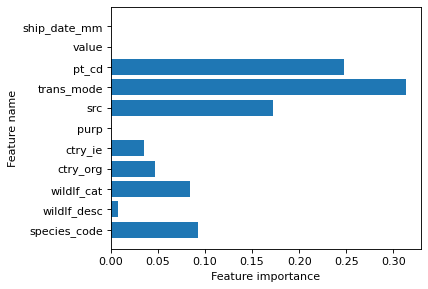

Feature importances: [0.         0.         0.24787744 0.31326018 0.17197994 0.
 0.03532327 0.04719333 0.08394044 0.00782801 0.09259739]


In [38]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(rf_pipe_2.best_estimator_.named_steps['clf'], feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_pipe_2.best_estimator_.named_steps['clf'].feature_importances_[::-1]))